# Đọc


In [5]:
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

os.chdir("/Users/vophuhan/Everything/University/Năm 4/Semester 2/Ứng dụng Phân tích dữ liệu thông minh/21KHDL-TikTok-Analytics")

In [6]:
# Define data types for some columns
dtypes = {
    "id": np.object_,
    "video.id": np.object_,
    "video.videoID": np.object_,
    "user.commerceUserInfo.category": np.object_,
    "user.commerceUserInfo.categoryButton": np.object_,
    "BAInfo": np.object_,
    "user.bioLink.link": np.object_,
}

In [7]:
df = pd.read_csv(
    "notebooks/analyse/content_analyse.csv", dtype=dtypes)  # hoặc đã có sẵn
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   year                1400 non-null   int64  
 1   week                1400 non-null   int64  
 2   weekly_score        1400 non-null   float64
 3   weekly_score_rank   1400 non-null   float64
 4   username            1400 non-null   object 
 5   video.id            1400 non-null   object 
 6   desc                1399 non-null   object 
 7   video.duration_x    1400 non-null   float64
 8   hashtags            1393 non-null   object 
 9   num_hashtags        1400 non-null   int64  
 10  engagement_rate     1400 non-null   float64
 11  video.url           1400 non-null   object 
 12  transcript          1332 non-null   object 
 13  category            1397 non-null   object 
 14  hook_type           1397 non-null   object 
 15  structure_style     1094 non-null   object 
 16  tone_o

In [8]:
df['has_cta'].value_counts()

has_cta
True     1175
False     222
Name: count, dtype: int64

In [23]:
df['cta_type'][df['cta_type'] == "[nan]"] = []

/var/folders/5s/3t7kh6rn1_5_jk7f9tjf_zrh0000gn/T/ipykernel_71928/607229068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cta_type'][df['cta_type'] == "[nan]"] = []


# Visual


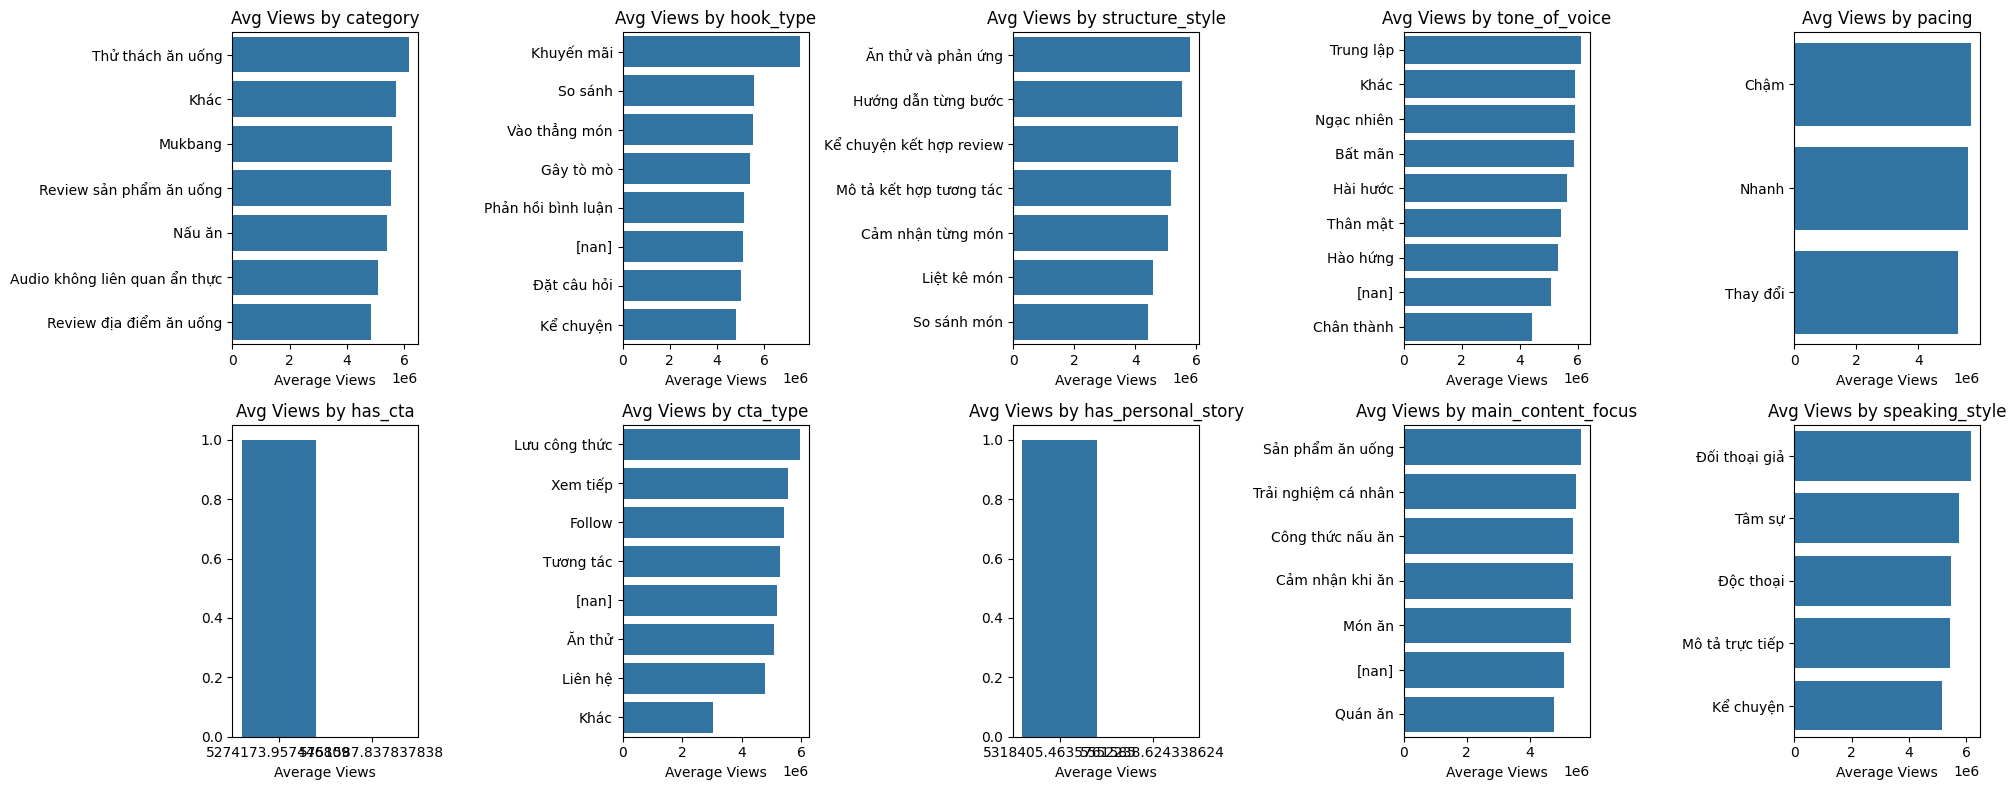

In [4]:
# Danh sách các cột cần phân tích
list_columns = [
    'category', 'hook_type', 'structure_style', 'tone_of_voice', 'pacing',
    'has_cta', 'cta_type', 'has_personal_story', 'main_content_focus',
    'speaking_style'
]

# Hàm xử lý chuyển chuỗi list -> list thực sự


def parse_list_column(value):
    try:
        parsed = ast.literal_eval(value) if isinstance(
            value, str) and value.startswith('[') else value
        return parsed if isinstance(parsed, list) else [parsed]
    except:
        return [value]


# Áp dụng parse cho các cột list
for col in list_columns:
    df[col] = df[col].apply(parse_list_column)

# Vẽ biểu đồ lượt xem trung bình cho từng nhãn trong mỗi cột
num_cols = 5
num_rows = (len(list_columns) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
axes = axes.flatten()

for i, col in enumerate(list_columns):
    exploded = df[['views', col]].explode(col)
    grouped = exploded.groupby(
        col)['views'].mean().sort_values(ascending=False)
    sns.barplot(x=grouped.values, y=grouped.index, ax=axes[i])
    axes[i].set_title(f'Avg Views by {col}')
    axes[i].set_xlabel('Average Views')
    axes[i].set_ylabel(None)

# Ẩn subplot thừa nếu có
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [25]:
def parse_list_field(val):
    if pd.isna(val):
        return []
    try:
        parsed = ast.literal_eval(val)
        if isinstance(parsed, list):
            return [x for x in parsed if pd.notna(x)]
    except:
        pass
    # Nếu không parse được (ví dụ chuỗi "nan"), trả về rỗng
    return []


# Tạo danh sách kết hợp (hook, tone) cho mỗi video
df['hook_list'] = df['hook_type'].apply(parse_list_field)
df['tone_list'] = df['tone_of_voice'].apply(parse_list_field)

# Tạo cột các cặp (hook, tone) cho mỗi video
df['hook_tone_combos'] = df.apply(
    lambda row: [(h, t) for h in row['hook_list'] for t in row['tone_list']], axis=1)

# Explode các combo
combo_exploded = df.explode('hook_tone_combos')
combo_exploded = combo_exploded[combo_exploded['hook_tone_combos'].notna()]

# Tính trung bình views theo combo (hook, tone)
combo_avg = combo_exploded.groupby('hook_tone_combos')[
    'views'].mean().sort_values(ascending=False)
print("Top 5 combo hook-tone:")
print(combo_avg.head(5))

Top 5 combo hook-tone:
hook_tone_combos
(Khuyến mãi, Thân mật)    7520000.0
(Khuyến mãi, Hào hứng)    7520000.0
(Kể chuyện, Trung lập)    6600000.0
(Gây tò mò, Khác)         6375000.0
(Gây tò mò, Trung lập)    6062500.0
Name: views, dtype: float64


In [26]:
import pandas as pd
import plotly.express as px

# Chuyển combo_avg (index là tuple) thành DataFrame
combo_df = combo_avg.reset_index()
combo_df[['hook', 'tone']] = pd.DataFrame(
    combo_df['hook_tone_combos'].tolist(), index=combo_df.index)
combo_df = combo_df.rename(columns={'views': 'avg_views'})

# Pivot thành dạng ma trận cho heatmap
heatmap_data = combo_df.pivot(index='tone', columns='hook', values='avg_views')

# Vẽ heatmap
fig = px.imshow(
    heatmap_data,
    text_auto=True,
    color_continuous_scale='Viridis',
    labels=dict(x="Hook Type", y="Tone of Voice", color="Avg Views"),
    title="Heatmap: Average Views theo Combo (Hook - Tone)"
)

fig.update_layout(
    xaxis_title="Hook Type",
    yaxis_title="Tone of Voice",
    autosize=False,
    width=800,
    height=600
)

fig.show()